# Inferência nos nós

Não podemos aplicar métodos tradicionais de regressão em Grafos pois os dados não são iid. As Graph Convolutional Networks propõe uma alternativa ao realizar convoluções (message passing), transformações não lineares e uma MLP no final. No trabalho Simplifying Graph Convolutional Networks os autores reduzem a complexidade da rede removendo as funções de ativação e obtém uma arquitetura (SGC) correspondente a um filtro low-pass seguido de um classificador linear. O resultado é consistente em datasets maiores e naturalmente interpretável.

Podemos predizer o Outbreak Size (ou outra variável) começando em um nó, a partir das características desse (clustering, medidas de centralidade) utilizando a abordagem SGC?

Obs.: eu utilizo uma versão com o Heat Kernel. A versão para classificação conforme GENERALIZING GRAPH CONVOLUTIONAL NETWORKS VIA HEAT KERNEL é mostrada abaixo

$$
Y = softmax(e^{−\Delta t}XW)
$$

In [11]:
import EoN
import os
import scipy

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
N = 500 # network size
tau = 0.25 # transmission rate per edge
gamma = 1 # recovery rate per node

In [ ]:
G = nx.barabasi_albert_graph(N, 10)

assert nx.is_connected(G)

feature_dict = {}

network_metrics = {
    'degree': nx.degree_centrality,
    'clustering': nx.clustering,
    'closeness': nx.closeness_centrality,
    'betweenness': nx.betweenness_centrality,
    'eigenvector': nx.eigenvector_centrality,
    'pagerank': nx.pagerank,
}

feature_dict = {}
for metric in network_metrics:
    feature_dict[metric] = network_metrics[metric](G)

outbreak_by_seed = []
for node in tqdm(G.nodes()):
    outbreak_size = []
    for _ in range(100):
        _, _, _, R = EoN.fast_SIR(G, tau, gamma, initial_infecteds=node)
        outbreak_size.append(R[-1])
    outbreak_by_seed.append(np.mean(outbreak_size)/N)

100%|██████████| 500/500 [06:53<00:00,  1.21it/s]


In [5]:
y = np.array(outbreak_by_seed)

In [6]:
def get_submatrix(matrix: np.array, indices: list) -> np.array:
    return matrix[np.ix_(indices, indices)]

In [8]:
train_size = 3/4
train_index = np.random.choice(list(range(N)), size=int(N*train_size), replace=False)
test_index = [x for x in list(range(N)) if x not in train_index]

In [16]:
t = 1
laplacian = nx.normalized_laplacian_matrix(G).toarray()
heat_kernel = scipy.linalg.expm(-t*laplacian)

features = pd.DataFrame(feature_dict)

In [46]:
tips = sns.load_dataset("tips")

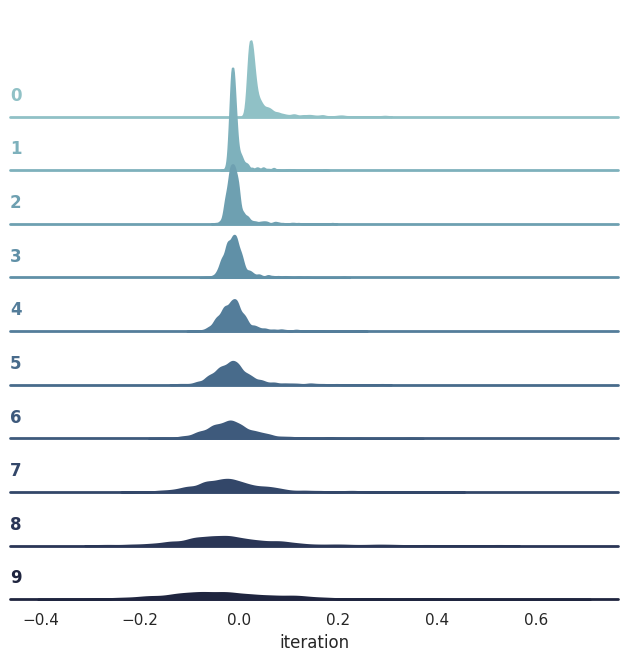

In [128]:
u = {0: features['degree']}
for i in range(9):
    u[i+1] = laplacian @ u[i]

u_df = pd.DataFrame(u)
u_df = u_df.melt(var_name='iteration')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(
    u_df, row="iteration", hue="iteration", aspect=10, height=0.7, palette=pal
)
g.map(
    sns.kdeplot, "value", bw_adjust=.5, clip_on=False,
    fill=True, alpha=1, linewidth=1.5
)
g.map(
    sns.kdeplot, clip_on=False, color="w", lw=2, bw_adjust=.5
)
g.refline(
    y=0, linewidth=2, linestyle="-", color=None, clip_on=False
)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "iteration")

g.figure.subplots_adjust(hspace=-.5)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [244]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

features_array = features.to_numpy()

# X = heat_kernel @ scaler.fit_transform(features)
X = features
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [106]:
class HKGCN(LogitRegression):
    """
    Transductive Learning on Graphs using Heat Kernel and Logit Regression
    """
    heat_kernel: np.array

    def __init__(self, t: int = 5):
        super().__init__()
        self.t = t
        self.scaler = MinMaxScaler()
        self.heat_kernel = None
    
    def get_heat_kernel(self, G: nx.Graph):
        if self.heat_kernel:
            return self.heat_kernel

        laplacian = nx.normalized_laplacian_matrix(G).toarray()
        self.heat_kernel = scipy.linalg.expm(-self.t*laplacian)
        return self.heat_kernel

    def propagate(self, G: nx.Graph, features: np.array):
        return self.get_heat_kernel(G) @ features

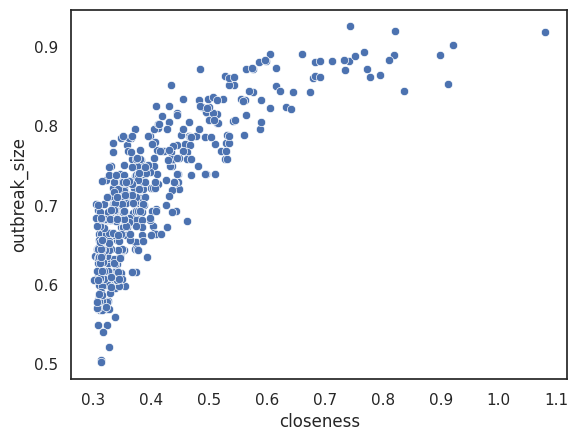

In [250]:
variable = 'closeness'

node_regression = HKGCN(t=2)
X = node_regression.propagate(G, np.array(features[variable]))

df = pd.DataFrame({
    variable: X,
    'outbreak_size': y
})

ax = sns.scatterplot(df, x=variable, y='outbreak_size')

In [324]:
from statsmodels.discrete.discrete_model import Poisson
import statsmodels.formula.api as smf
reg = Poisson(
    df.outbreak_size * 500, 
    sm.tools.add_constant(features.closeness),
    offset=[np.log(500)] * len(df.outbreak_size)
).fit()
print(reg.summary())

Optimization terminated successfully.
         Current function value: 4.784431
         Iterations 5
                          Poisson Regression Results                          
Dep. Variable:          outbreak_size   No. Observations:                  500
Model:                        Poisson   Df Residuals:                      498
Method:                           MLE   Df Model:                            1
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                  0.2347
Time:                        16:55:54   Log-Likelihood:                -2392.2
converged:                       True   LL-Null:                       -3126.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3655      0.027    -51.423      0.000      -1.418      -1.313
closeness      2.3878      0.

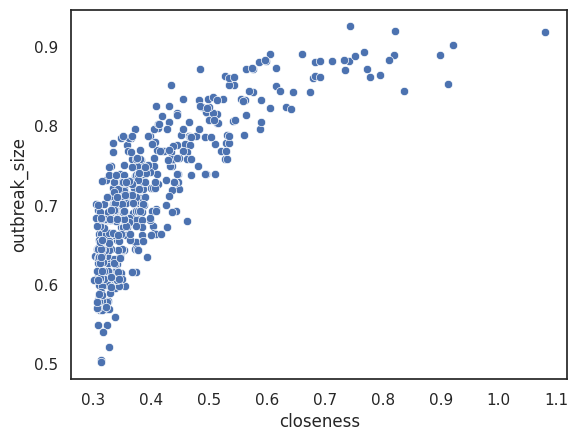

In [325]:
ax = sns.scatterplot(x=df.closeness, y=df.outbreak_size)

(0.35, 0.6)

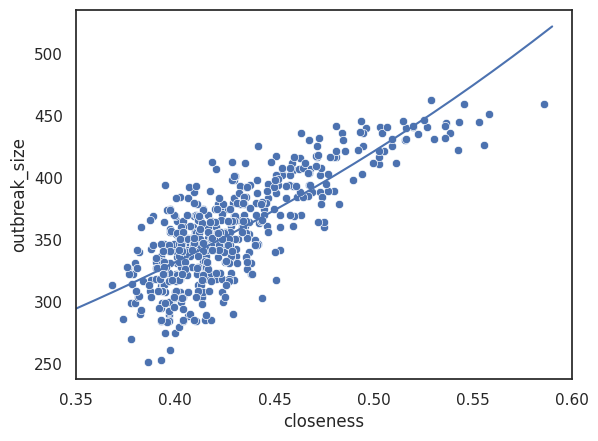

In [333]:
ax = sns.scatterplot(x=features.closeness, y=df.outbreak_size * 500)
x = np.arange(0.35, 0.6, 0.01)
p = reg.params
ax.plot(x, np.exp(p.const + p.closeness * x + np.log(500)))
ax.set_xlim([0.35, 0.6])


In [134]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=5, shuffle=True)

mean_values = []
std_values = []
t_values = list(np.arange(0, 1000, 10))

for t in tqdm(t_values):
    node_regression = HKGCN(t=t)
    X = node_regression.propagate(G, np.array(features[['closeness']]))
    scores = []
    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        node_regression.fit(X_train, y_train)
        scores.append(node_regression.score(X_test, y_test))
        
    mean_values.append(np.mean(scores))
    std_values.append(np.std(scores))

100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Text(0.5, 1.0, 'R2 score VS $t$')

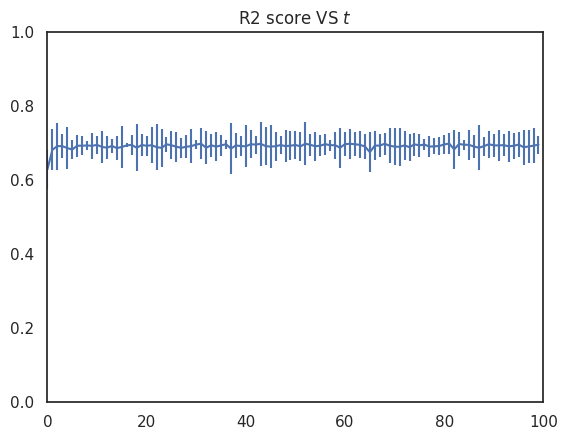

In [133]:
plt.errorbar(t_values, mean_values, std_values, mfc='red')
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.title('R2 score VS $t$')

In [122]:
node_regression = HKGCN(t=2.5)
X = node_regression.propagate(G, np.array(features[['closeness']]))
X_train, X_test, y_train, y_test = train_test_split(X, y)
node_regression.fit(X_train, y_train)
print('Score: ', node_regression.score(X_test, y_test))
print('Coefficients: ', node_regression.coef_)
y_pred = node_regression.predict(X_test)

Score:  0.7209061304787276
Coefficients:  [3.23395127]
